## CA1: Classification with MLP updated by Backprop from Scratch and RBF Networks with Random Selected Center Neurons. 

### Part 1: Classification with MLP updated by Backpropagation following gradient descent

#### a. First, generate the scatter data points using the given code.

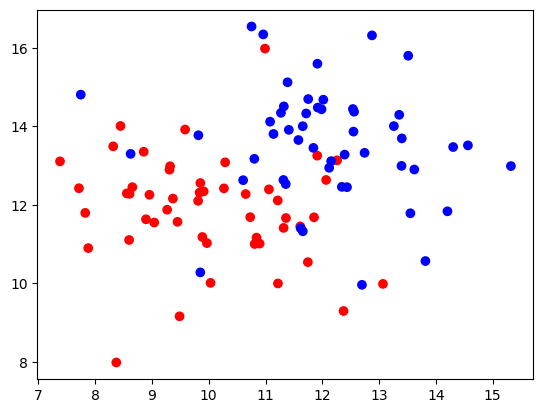

In [81]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.io as io

N1 = 50
N2 = 50
K = 2
sigma = 2

mean1 = (10, 12)
cov1 = [[sigma, 0], [0, sigma]]
X1 = np.random.multivariate_normal(mean1, cov1, N1)
c1 = ['red'] * len(X1)

mean2 = (12, 14)
cov2 = [[sigma, 0], [0, sigma]]
X2 = np.random.multivariate_normal(mean2, cov2, N2)
c2 = ['blue'] * len(X2)

X = np.concatenate((X1, X2))
color = np.concatenate((c1, c2))

T = []
for n in range(0, len(X)):
    if (n < len(X1)):
        T.append(0)
    else:
        T.append(1)

plt.scatter(X[:, 0], X[:, 1], marker = 'o', c = color)
plt.show()

np.save('class1.npy', X1)
np.save('class2.npy', X2)
io.savemat('class1.mat', {'class1': X1})
io.savemat('class2.mat', {'class2': X2})

#### b. Next, implement a multi-layer perceptron for classification. 

#### First I draw the general structure of the MLP for better understanding of the process.

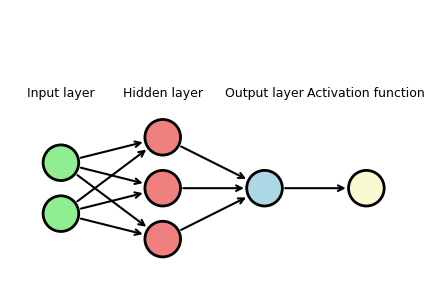

In [13]:
import matplotlib.pyplot as plt
import numpy as np

def draw_mlp(input_size, hidden_size, output_size, activation_size=1):
    # Adjust the figure size: wider and shorter
    fig, ax = plt.subplots(figsize=(12, 4))  # Adjusted width and reduced height

    # Define layer sizes, now including the activation function layer
    layer_sizes = [input_size, hidden_size, output_size, activation_size]
    v_spacing = 1
    h_spacing = 2
    neuron_radius = 0.35  # Increased radius for larger circles

    # Define positions for neurons in each layer
    neuron_positions = []
    layer_colors = ['lightgreen', 'lightcoral', 'lightblue', 'lightgoldenrodyellow']  # Different colors for each layer

    for i, layer_size in enumerate(layer_sizes):
        x = i * h_spacing
        layer_positions = [(x, v_spacing * (j - (layer_size - 1) / 2)) for j in range(layer_size)]
        neuron_positions.append(layer_positions)

    # Plot neurons as larger circles with different colors for each layer
    for i, layer_position in enumerate(neuron_positions):
        for (x, y) in layer_position:
            circle = plt.Circle((x, y), radius=neuron_radius, edgecolor='black', facecolor=layer_colors[i], lw=2)
            ax.add_patch(circle)

    # Plot connections as arrows, adjusted to point to circle edges
    def plot_arrow(x0, y0, x1, y1):
        # Calculate the direction vector
        dx, dy = x1 - x0, y1 - y0
        distance = np.sqrt(dx**2 + dy**2)

        # Normalize the direction vector and adjust for neuron radius
        norm_dx, norm_dy = dx / distance, dy / distance
        x0_adjusted = x0 + neuron_radius * norm_dx
        y0_adjusted = y0 + neuron_radius * norm_dy
        x1_adjusted = x1 - neuron_radius * norm_dx
        y1_adjusted = y1 - neuron_radius * norm_dy

        # Draw the arrow between the adjusted points
        ax.annotate("",
                    xy=(x1_adjusted, y1_adjusted), xycoords='data',
                    xytext=(x0_adjusted, y0_adjusted), textcoords='data',
                    arrowprops=dict(arrowstyle="->", lw=1.5, color="black"))

    for i in range(len(neuron_positions) - 1):
        for (x0, y0) in neuron_positions[i]:
            for (x1, y1) in neuron_positions[i + 1]:
                plot_arrow(x0, y0, x1, y1)

    # Set a consistent height for labels above all layers
    label_y_position = 1.8  # Adjusted y-position for all layer labels

    # Add consistent-height layer labels
    for i in range(len(neuron_positions)):
        layer_label = ['Input layer', 'Hidden layer', 'Output layer', 'Activation function'][i]
        ax.text(i * h_spacing, label_y_position, layer_label, fontsize=9, ha='center')  # Slightly larger font size

    # Adjust plot limits and layout to reduce whitespace
    ax.set_xlim(-1, h_spacing * 3 + 1)
    ax.set_ylim(-v_spacing * max(layer_sizes) / 2 - 0.5, v_spacing * max(layer_sizes) / 2 + 2.0)
    ax.set_aspect('equal')
    ax.axis('off')

    # Reduce the margins to remove excess whitespace
    plt.subplots_adjust(top=0.85, bottom=0.15, left=0.1, right=0.9)

    plt.show()

# Parameters for MLP structure
input_size = 2    # Input neurons
hidden_size = 3   # Hidden layer neurons
output_size = 1   # Output neuron
activation_size = 1  # Activation function neuron (after the output layer)

# Draw MLP structure with larger image and neurons but reduced height
draw_mlp(input_size, hidden_size, output_size, activation_size)


#### Then I implement the MLP for classification.

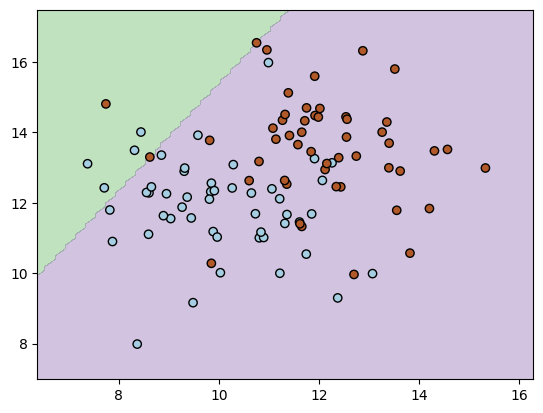

Initial classification accuracy: 51.00%


In [1]:
import scipy.io as io

# Sigmoid activation function
def sigmoid(x):

    return 1 / (1 + np.exp(-x))

# Derivative of sigmoid
def sigmoid_derivative(x):
    
    return x * (1 - x)

# Initialize weights for sigmoid function and random biases
def initialize_parameters(input_size, hidden_size, output_size):
    
    # Randomly initialize the weights
    np.random.seed(1)
    W1 = np.random.randn(input_size, hidden_size)
    b1 = np.zeros((1, hidden_size))
    W2 = np.random.randn(hidden_size, output_size)
    b2 = np.zeros((1, output_size))
    return W1, b1, W2, b2

# Forward propagation function with bias
def forward_propagation(X, W1, b1, W2, b2):
    
    # Compute the hidden layer activation
    Z1 = np.dot(X, W1) + b1  # Add bias term to the input to hidden layer
    hidden_output = sigmoid(Z1)
    
    # Compute the output layer activation
    Z2 = np.dot(hidden_output, W2) + b2  # Add bias term to the input to hidden layer
    final_output = sigmoid(Z2)
    
    return hidden_output, final_output

# Generate decision boundary plot with two colors
def plot_decision_boundary(X, T, W1, b1, W2, b2):
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    
    # Create a grid of points
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))
    P = np.c_[xx.ravel(), yy.ravel()]  # Flatten the grid points
    _, P_out = forward_propagation(P, W1, b1, W2, b2)  # Get output predictions for grid points
    
    # Convert continuous outputs to binary
    P_out = np.round(P_out).reshape(xx.shape)  # Reshape the output predictions to match grid shape
    
    # Plot the decision boundary with two distinct colors
    plt.contourf(xx, yy, P_out, alpha=0.3, levels=[0, 0.5, 1], cmap=plt.cm.Paired)  # Use two color levels
    
    # Plot the data points
    plt.scatter(X[:, 0], X[:, 1], c=T, edgecolor='k', marker='o', cmap=plt.cm.Paired)
    plt.show()

# Load the data generated from Part 1a
X = np.concatenate((np.load('class1.npy'), np.load('class2.npy')))
T = np.concatenate((np.zeros(50), np.ones(50))).reshape(-1,1)

# Calculate Classification accuracy
def calculate_accuracy(X, T, W1, b1, W2, b2):
    
    # Compute the accuracy of the model predictions
    _, final_output = forward_propagation(X, W1, b1, W2, b2)  # Perform forward propagation
    predictions = np.round(final_output)  # Round predictions to get binary output
    accuracy = np.mean(predictions == T.reshape(-1, 1)) * 100  # Calculate accuracy percentage
    return accuracy

# Initialize parameters with bias
input_size = 2  # Two input features
hidden_size = 3  # Three hidden neurons
output_size = 1  # One output neuron
W1, b1, W2, b2 = initialize_parameters(input_size, hidden_size, output_size)  # Initialize weights and biases

# Plot initial decision boundary
plot_decision_boundary(X, T, W1, b1, W2, b2)

# Initial classification accuracy
initial_accuracy = calculate_accuracy(X, T, W1, b1, W2, b2)
print(f"Initial classification accuracy: {initial_accuracy:.2f}%")

The initial decision boundary plot shows how the random initialization leads to a poorly performing model. At this step, the classification accuracy is expected to be close to random guessing (around 50%). And the result shows that indeed the accuracy is 51%, meaning the classifier no difference to a simple guess. This poor performance is expected because the weights in the MLP are initialized randomly, following a normal distribution. However, these initial random weights don't represent any accuracy in classification.

The MLP has 2 input neurons, 3 hidden neurons and 1 output neuron. With random weight initialization, the decision boundary is misleading, meaning that the MLP doesn't know how to separate the two classes in the dataset effectively. This poor performance emphasizes the importance of training the model through the backpropagation and gradient descent process to optimize the weight values so that the model can learn from the data.

Moreover, the initial decision boundary plot shows that the boundary is poorly aligned with the actual distribution of the data points. Since the points in each class are generated randomly, there will be some overlap between classes. The initial decision boundary does not make use of the patterns in the data to separate the classes. This creates a highly mixed-up boundary, visually demonstrating that the model is making guesses, with no difference to simply pick up a point and say its class randomly.

One key realization from this step is the challenge in training the MLP effectively. The random weight initialization illustrates how crucial it is to guide the model to a better solution using an optimization process like gradient descent. While random guessing gives a point to start, it's the process of training that truly discovers the structure in the data and leads to meaningful decision boundaries.

Another important thing is the complexity introduced by the hidden layer. While the 3 hidden neurons have the potential to model non-linear relationships between the input features and the output class, this potential is entirely discarded without proper training. The random initialization essentially leads to a linear separation, as the hidden layer connections are not yet effectively utilizing their capacity.

#### c. Update the weights of the MLP using backpropagation.

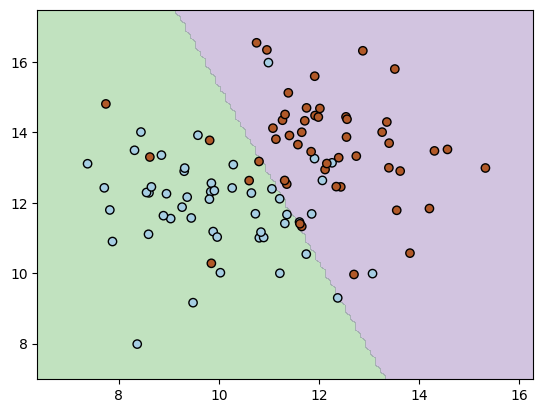

Final classification accuracy: 87.00%


In [18]:
# Cross-Entropy Loss function
def binary_cross_entropy_loss(y_true, y_pred):
    y_pred = np.clip(y_pred, 1e-10, 1 - 1e-10)  # Add a small parameter to avoid log(0)
    return -np.mean(y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))

# Derivative of Cross-Entropy Loss with respect to output
def binary_cross_entropy_loss_derivative(y_true, y_pred):
    y_pred = np.clip(y_pred, 1e-10, 1 - 1e-10)  # Add a small parameter to avoid log(0)
    return (y_pred - y_true) / (y_pred * (1 - y_pred))

# Backpropagation function with cross-entropy loss
def backward_propagation(X, T, hidden_output, final_output, W1, b1, W2, b2, learning_rate):

    # Number of training examples
    m = X.shape[0]
    
    # Calculate output layer error
    dZ2 = binary_cross_entropy_loss_derivative(T, final_output)  # dZ2 shape (100,1)
    dW2 = np.dot(hidden_output.T, dZ2) / m  # dW2 update, shape (3,1)
    db2 = np.sum(dZ2, axis=0, keepdims=True) / m  # db2 update, shape (1,1)

    # Calculate hidden layer error
    dA1 = np.dot(dZ2, W2.T)  # dA1 shape (100,3)
    dZ1 = dA1 * sigmoid_derivative(hidden_output)  # Apply derivative of sigmoid to hidden layer
    dW1 = np.dot(X.T, dZ1) / m  # dW1 update, shape (2,3)
    db1 = np.sum(dZ1, axis=0, keepdims=True) / m  # db1 update, shape (1,3)

    # Update weights and biases
    W2 -= learning_rate * dW2
    b2 -= learning_rate * db2
    W1 -= learning_rate * dW1
    b1 -= learning_rate * db1

    return W1, W2, b1, b2

# Training the model
epochs = 100000
learning_rate = 0.004

for epoch in range(epochs):
    
    # Calculate the output values
    hidden_output, final_output = forward_propagation(X, W1, b1, W2, b2)
    
    # Calculate loss
    loss = binary_cross_entropy_loss(T, final_output)
    
    # Perform backpropagation
    W1, W2, b1, b2 = backward_propagation(X, T, hidden_output, final_output, W1, b1, W2, b2, learning_rate)

# Plot final decision boundary
plot_decision_boundary(X, T, W1, b1, W2, b2)

# Final classification accuracy
final_accuracy = calculate_accuracy(X, T, W1, b1, W2, b2)
print(f"Final classification accuracy: {final_accuracy:.2f}%")

In this step I use the cross entropy loss to compute the losses. The cross entropies of true and predicted labels are computed and further by using the chain rule in gradient descent I update the weights over all 100 data entries. The function calculates the negative log of the predicted probabilities for the correct class, ensuring that incorrect predictions are penalized more heavily. By minimizing the loss function, the model learns to adjust the weights that reduces the difference between predicted and true class labels and thus generalizes a certain pattern among the data.

Comparison of the initial MLP and updated MLP:

Before updating, the boundary is linear and cannot classify the classes very correctly. After updating, the boundary can separate the two classes with a certain degree of accuracy of 87%. The updated decision boundary now align more closely with the actual boundary that separates the two classes. The hidden layer of the MLP learns to create more accurate decision boundaries, and after some weight updates, the model can better distinguish between the two classes. This process illustrates the effectiveness of backpropagation in training MLPs, gradually improving performance by adjusting the weights based on gradient descent. The boundary now fits the data more smoothly, allowing the MLP to separate the two classes more effectively than before. However, as can be seen in the image, there're still a certain degree of brown points that are not classified correctly, meaning there can still be an improvement in the algorithm.

Moreover, the network's ability to learn nonlinear decision boundaries is critical for complex datasets, especially when the data points are not linearly separable. Initially, with random weights, the decision boundary is linear, reflecting the model doesn't have the capability to capture complex relationships in the data. As training progresses, the hidden layer in the MLP adjusts the weights and biases to transform the feature space. The hidden neurons begin to detect patterns and correlations. This transformation of the input space allows the network to generate curved decision boundaries, which can separate more complex class distributions. The backpropagation algorithm continuously updates the weights, enabling the network to discover these patterns in the data.

Throughout the training process, the learning rate is another critical factor. I tuned many parameters and discovered that a small learning rate ensures the weight updates are gradual, preventing the model from crossing the optimal solution. If the learning rate is too large, the decision boundary also performs poorly. By maintaining a suitable learning rate, the model steadily paces towards a solution that accurately captures the differences between the two classes. And when it comes to the number of epochs I ran, it has a relevant impact on the accuracy, during my training, it seems like that epochs = 10000 and epochs = 30000 have similar results in accuracy, however, when I increase the epochs to a significant amount such as 100000, the accuracy improves distinctly.

One interesting note from this step is the importance of balancing the learning rate and the number of training epochs. While a higher learning rate can speed up the training process, it may cause the model to cross the optimal solution, resulting in poor performance. On the other hand, a very small learning rate can lead to a slow convergence, making the training inefficient. Finding the optimal spot is crucial to achieving a model that generalizes well. In this step, after many tuning, I chose a learning rate of 0.004.

Another thing is that while the boundary becomes more accurate after weight updates, I can observe that it still misclassifies some points. This suggests that even after applying backpropagation, certain patterns in the data remain difficult for the model to capture. This comes from the complexity of the data distribution or from the limitations of the model itself. While the MLP is flexible enough to capture non-linear relationships, it may not be sufficient for highly complex datasets without further uodates.

Additionally, this step emphasizes the role of overfitting in neural networks. As the decision boundary becomes more precise, it is likely to continue pushing for higher accuracy on the training set. However, this may lead to overfitting, where the model memorizes the training data rather than generalizing well on unseen data.

Finally, each weight update can be seen as the network learning to detect more intricate patterns and the gradual improvement of the decision boundary serves as a visualization of the learning process.

### Part 2: Classification with RBF Network with Random RBF Centers

#### a. Leverage the RBF network for the same data with 3 centers.

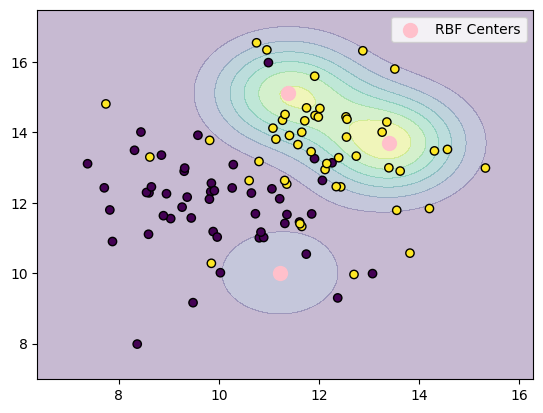

RBF classification accuracy: 77.00%


In [75]:
from scipy.spatial.distance import cdist

# RBF Gaussian function
def gaussian_rbf(x, c, s):
    return np.exp(-cdist(x, c)**2 / (2 * s**2))

# Randomly select RBF centers within data range
def random_centers(X, num_centers):
    n = np.random.choice(len(X), num_centers, replace=False)
    return X[n]

# RBF Network with 3 random centers
num_centers = 3
centers = random_centers(X, num_centers)
sigma = 1  # Width of Gaussian

# Generate RBF output (hidden layer)
H = gaussian_rbf(X, centers, sigma)

# Compute H^T * H
HtH = np.dot(H.T, H)

# Compute H^T * T
HtT = np.dot(H.T, T)

# Compute the inverse of H^T * H
HtH_inv = np.linalg.inv(HtH)

# Solve for W using the normal equation W = (H^T H)^(-1) * (H^T T)
# Compute the weights W by what I've learnt in Lecture 3 about Least Square estimation
W_rbf = np.dot(HtH_inv, HtT)

# Decision boundary plot for RBF (similar to the MLP's plot_decision_boundary)
def plot_rbf_decision_boundary(X, T, centers, W_rbf, sigma):
    
    # Define grid range for the plot
    x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
    y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
    
    # Create a grid of points
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                         np.arange(y_min, y_max, 0.1))
    
    Z = np.c_[xx.ravel(), yy.ravel()]  # Flatten the grid points
    H_Z = gaussian_rbf(Z, centers, sigma)  # Apply Gaussian_rbf kernel
    Z_out = np.dot(H_Z, W_rbf)  # Get output predictions for grid points
    Z_out = Z_out.reshape(xx.shape)  # Reshape the output predictions to match grid shape
    
    plt.contourf(xx, yy, Z_out, alpha=0.3)
    plt.scatter(X[:, 0], X[:, 1], c=T, edgecolor='k', marker='o')
    plt.scatter(centers[:, 0], centers[:, 1], color='pink', s=100, label='RBF Centers')
    plt.legend()
    plt.show()

# Plot the decision boundary for RBF network
plot_rbf_decision_boundary(X, T, centers, W_rbf, sigma)

# Classification accuracy for RBF
rbf_output = np.dot(H, W_rbf)
rbf_predictions = np.round(rbf_output)
rbf_accuracy = np.mean(rbf_predictions == T) * 100
print(f"RBF classification accuracy: {rbf_accuracy:.2f}%")


Unlike the MLP, which uses learned weights to create decision boundaries through hidden layers of neurons, the RBF network generates decision boundaries based on the distances between the data points and a set of centers. These centers serve as the core points around which the RBF neurons operate. Each neuron computes a Gaussian function based on the distance between a data point and the neuron’s center. The closer a data point is to a center, the more influence that center will have on the neuron, and on the final classification decision. So by randomly choosing data centers, the accuracy fluctuates.

When using 3 hidden neurons with randomly chosen centers, the decision boundary is circular because the RBF network is distance-based. The Gaussian function used in the hidden neurons produces localized effects around the centers, resulting in smoother and more flexible decision boundaries compared to the MLP. However, the choice of corners heavily affects the accuracy of the RBF network because the centers are randomly initialized within the range of the dataset. I ran the block several times and got some varying accuracies such as 59%, 66% and 70% or so. So the accuracy itself really doesn't matter too much, the important thing is that its decision boundary is different from the MLP and its operating mechanism is distance-based.

Comparison of the MLP and RBF:

The RBF network’s decision boundary is different from the MLP’s boundary, presenting as circles, as RBF networks are more localized. The classification accuracy is a little bit lower than the updated MLP’s 87%, reaching 77%. However, as I repeat this process several times, the centers change and the accuracy also changes, so the comparison with MLP is dynamic depending on centers. This is partly due to center selection: If the centers are poorly chosen, the decision boundary may not align well with the actual distribution of the data, leading to lower classification performance. Additionally, because RBF networks are more localized, they're generally less capable of handling global situations compared to MLP, which is better at learning complex patterns through backpropagation.

One observation from this comparison is the intrinsic difference in how RBF networks and MLPs handle the data. While the MLP relies on weight adjustments across layers to create a learned decision boundary, the RBF network operates in a much more localized manner. This localization introduces some kind of neighborhood effect, where decisions are strongly influenced by the distance of data points to the chosen centers. The closer the data point is to the center, the more effect it will have on the decision boundary. This leads to a dynamic flow in how RBF networks evolve during training, and for MLPs, they rely more on learning from the entire dataset and less on how well the centers are chosen to represent local points.

This approach emphasizes the importance of data structure in RBF networks. Since the decision boundary depends on the spatial distribution of data points around the centers, well-distributed centers are critical. Choosing bad centers can make it hard for the network to create a good decision boundary, showing that smart center initialization is important. This is especially true for datasets with many dimensions or complex patterns, where picking centers randomly might not work well. Using other certain methods to select initial centers can help RBF networks perform better.

RBF networks naturally provide some regularization because they use distance-based methods. The Gaussian function creates smoother decision boundaries, which helps prevent overfitting. This is especially helpful compared to MLPs, which can overfit without proper regularization. However, this smoothness can also make RBF networks less effective on datasets that need more global decision-making.

#### b. Leverage the RBF network for the same data with 6 centers.

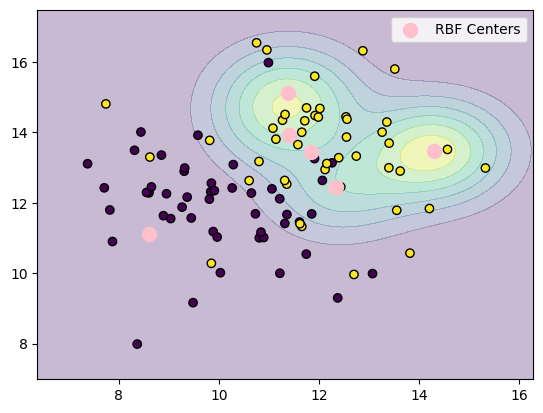

RBF classification accuracy: 82.00%


In [69]:
# RBF Network with 6 random centers
num_centers1 = 6
centers1 = random_centers(X, num_centers1)
sigma = 1  # Width of Gaussian

# Generate RBF output (hidden layer)
H1 = gaussian_rbf(X, centers1, sigma)
H1tH1 = np.dot(H1.T, H1)
H1tT = np.dot(H1.T, T)
H1tH1_inv = np.linalg.inv(H1tH1)

# Solve for W using the normal equation W = (H^T H)^(-1) * (H^T T)
# Compute the weights W by what I've learnt in Lecture 3 about Least Square estimation
W_rbf1 = np.dot(H1tH1_inv, H1tT)

# Plot the decision boundary for RBF network
plot_rbf_decision_boundary(X, T, centers1, W_rbf1, sigma)

# Classification accuracy for RBF
rbf_output1 = np.dot(H1, W_rbf1)
rbf_predictions1 = np.round(rbf_output1)
rbf_accuracy1 = np.mean(rbf_predictions1 == T) * 100
print(f"RBF classification accuracy: {rbf_accuracy1:.2f}%")


Comparison of 3-centers RBF and 6-centers RBF:

Increasing the number of hidden neurons generally improves the flexibility of the decision boundary, allowing the RBF network to fit more complex patterns in the data. However, there is a risk of overfitting if too many centers are chosen, especially if the data is finite. The 6-center RBF network achieves an accuracy of 82%, performing slightly better than the 3-center RBF network but lower than the updated MLP. This improvement can be attributed to the increased capacity of the network to model complex and nonlinear relationships in the data. With more neurons, the RBF network can capture more intricate details in the dataset, which allows for better separation of the two classes and leads to a higher accuracy. The phenomenon is the same as the 3-center RBF, with each running, the accuracy fluctuates.

However, there is a dilemma between increasing the number of neurons and overfitting. Overfitting occurs when the model becomes too specialized in fitting the training data and capturing noises. With 6 centers, the network's decision boundary becomes more precise and flexible, but with too many centers, the network could start fitting the training data too closely, resulting in poor generalization on unseen data. In this dataset, both 3-center and 6-center RBF networks can both classify the two classes, but the decision boundary for the 6-center network is more complex. Therefore, while the 6-center RBF network performs better in this data, the number of centers needs to be carefully selected to maintain the balance between accuracy and generalization to avoid overfitting.

Comparison of the MLP and RBF:

In general, the comparison between MLP and RBF shows how different architectures solve the classification problem from different perspectives. While the MLP relies on learned weights and backpropagation to form decision boundaries, the RBF network uses distance-based calculations and center neurons to achieve localized boundaries. The choice of parameters such as learning rates and the number of centers can greatly influence performance and the complexity of the decision boundaries.

Another point is the balance between complexity and simplicity. While adding more centers can help RBF networks capture intricate relationships in the data, this also comes at a cost. The risk of overfitting, especially with finite or noisy datasets, emphasizes the need to find a balance where the model is complex enough to learn meaningful patterns but not so complex that it becomes too sensitive to noise. This situation also underlies the critical role of hyperparameter tuning, while adding more centers can directly impact model performance, there is no guarantee that these adjustments will lead to better results.

Finally, this project reminds me that there is no one-size-fits-all solution in machine learning. Both RBF networks and MLPs have their strengths and weaknesses, and their performance is highly dependent on the structure of the data and the chosen hyperparameters. The fluctuating accuracy in RBF networks based on center selection is a vivid example of how sensitive these models can be to initialization, where MLPs benefit from global learning but require more careful tuning to avoid overfitting. This realization further emphasizes the importance of trying with multiple models and understanding the underlying data patterns when tackling classification problems.